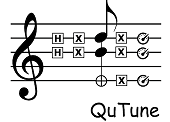

Supplementary material for book chapter: 

**_Quantum Computer Music: Foundations and Initial Experiments_**, by Eduardo R. Miranda and Suchitra T. Basak

(a) This demonstration is implemented in IBM Q's Qiskit. (https://qiskit.org/)

(b) To listen to the music you need run this Notebook alongside "MusicPatch.maxpat". Open the patch provided and make sure it plays musical notes on your computer. This patch sends out MIDI notes to your machine's default MIDI device, via UDP.

(c) Max is available from https://cycling74.com/

In [1]:
# import libraries
import numpy as np

from qiskit import QuantumCircuit, QuantumRegister, Aer, assemble, execute
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Defining the transition table

E = [0.,0.5,0.,0.,0.,0.5,0.,0.,0.,0.,0.,0.]
Ds = [0.25,0.,0.,0.25,0.25,0.,0.25,0.,0.,0.,0.,0.]
Cs = [0.,0.,0.33,0.,0.33,0.33,0.,0.,0.,0.,0.,0.]
G = [0.,0.33,0.,0.33,0.,0.,0.,0.33,0.,0.,0.,0.]
D = [0.,0.25,0.25,0.,0.,0.,0.25,0.,0.25,0.,0.,0.]
F = [0.25,0.,0.25,0.,0.,0.,0.,0.25,0.,0.25,0.,0.]
C = [0.,0.25,0.,0.,0.25,0.,0.,0.,0.25,0.,0.25,0.]
Fs = [0.,0.,0.,0.25,0.,0.25,0.,0.,0.,0.25,0.25,0.]
A = [0.,0.,0.,0.,0.25,0.,0.25,0.,0.,0.25,0.,0.25]
Gs = [0.,0.,0.,0.,0.,0.25,0.,0.25,0.25,0.,0.25,0.]
B = [0.,0.,0.,0.,0.,0.,0.25,0.25,0.,0.25,0.,0.25]
As = [0.,0.,0.,0.,0.,0.,0.,0.,0.5,0.,0.5,0.]

rules = {'E':E, 'Ds':Ds, 'Cs':Cs, 'G':G, 'D':D, 'F':F, 'C':C, 'Fs':Fs, 'A':A, 'Gs':Gs, 'B':B, 'As':As}
next_notes = {'E':64,'F':65,'G':67,'Cs':61,'Fs':66,'Ds':63,'Gs':68,'D':62,'B':71,'C':60,'A':69,'As':70}

In [3]:
# displaying Markov Chain as an array

mkv_chain = np.array([E,Ds,Cs,G,D,F,C,Fs,A,Gs,B,As])

print(mkv_chain)

[[0.   0.5  0.   0.   0.   0.5  0.   0.   0.   0.   0.   0.  ]
 [0.25 0.   0.   0.25 0.25 0.   0.25 0.   0.   0.   0.   0.  ]
 [0.   0.   0.33 0.   0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.33 0.   0.33 0.   0.   0.   0.33 0.   0.   0.   0.  ]
 [0.   0.25 0.25 0.   0.   0.   0.25 0.   0.25 0.   0.   0.  ]
 [0.25 0.   0.25 0.   0.   0.   0.   0.25 0.   0.25 0.   0.  ]
 [0.   0.25 0.   0.   0.25 0.   0.   0.   0.25 0.   0.25 0.  ]
 [0.   0.   0.   0.25 0.   0.25 0.   0.   0.   0.25 0.25 0.  ]
 [0.   0.   0.   0.   0.25 0.   0.25 0.   0.   0.25 0.   0.25]
 [0.   0.   0.   0.   0.   0.25 0.   0.25 0.25 0.   0.25 0.  ]
 [0.   0.   0.   0.   0.   0.   0.25 0.25 0.   0.25 0.   0.25]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.5  0.   0.5  0.  ]]


#### Step 1: Extract target states

In [4]:
E = [0.,0.5,0.,0.,0.,0.5,0.,0.,0.,0.,0.,0.]

def get_target_states(mkv_chain_one_row):
    target_states =[]
    for i in range(len(mkv_chain_one_row)):
        if mkv_chain_one_row[i] != 0.:
            target_states.append(1.)
        else:
            target_states.append(0.)
    return(target_states)

print(E)
get_target_states(E)

[0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

#### Step 2: Make oracle

In [5]:
def make_oracle(target_states,num_qubits):
    oracle_mat = np.eye(2**num_qubits)
    
    for i in range(len(target_states)):
        if target_states[i] == 1.:
            oracle_mat[i,i] = -1.
    return(oracle_mat)

p = make_oracle(get_target_states(E), 4)
print(p)

[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

#### Step 3: Build circuit

In [6]:
def build_circuit(num_qubits, target_states):
    
    def initialize(qc,num_qubits):
        for i in range(num_qubits):
            qc.h(i)
        return(qc)
    
    def oracle(qc, num_qubits, target_states):
        inputs_q = QuantumRegister(num_qubits)
        opQc = QuantumCircuit(inputs_q)

        # create the matrix/ truthtable
        mat = make_oracle(target_states,num_qubits)
        
        #print(mat)
        # pack the oracle in a gate
        op = Operator(mat)
        opQc.unitary(op, list(range(num_qubits)), label='oracle for')

        orc = opQc.to_gate()
        orc.name = "$Oracle$"

        qc.append(orc, list(range(num_qubits)))
        return(qc)
    
    # diffuser circuit
    def diffuser(qc, nqubits):
        for qubit in range(nqubits):
            qc.h(qubit)

        for qubit in range(nqubits):
            qc.x(qubit)
        
        qc.h(nqubits-1)
        qc.mct(list(range(nqubits-1)), nqubits-1)  # mct = multi-controlled-toffoli
        qc.h(nqubits-1)
        
        for qubit in range(nqubits):
            qc.x(qubit)
        
        for qubit in range(nqubits):
            qc.h(qubit)

        return(qc)
    
    qc = QuantumCircuit(num_qubits)
    qc = initialize(qc, num_qubits)
    qc.barrier()
    qc = oracle(qc, num_qubits, target_states)
    qc.barrier()
    qc = diffuser(qc,num_qubits)
    
    qc.measure_all()
    
    return(qc)

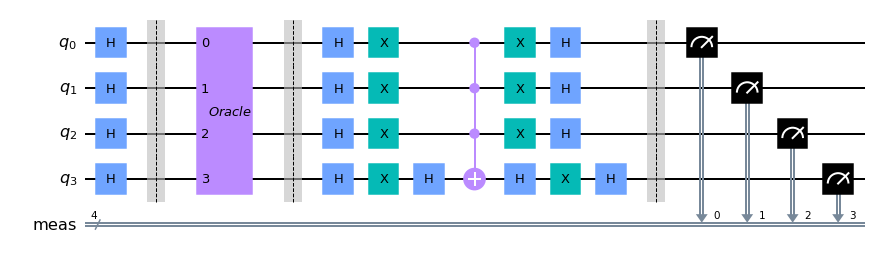

In [7]:
qc = build_circuit(4,get_target_states(E))
qc.draw('mpl')

In [8]:
# execute circuit
def get_histogram(qc):
    # this function prints the histogram of the circuit
    backend = Aer.get_backend('qasm_simulator')
    results = execute(qc,backend).result().get_counts()
    return(results)

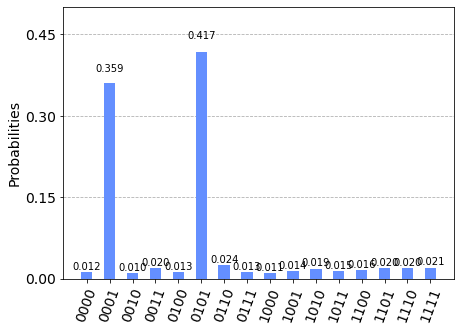

In [9]:
answer = get_histogram(qc)
plot_histogram(answer)

In [10]:
# Calculate next value from the histogram

def calc_next_note(answer):
    dict_keys = list(answer.keys())
    dict_vals = []
    for i in dict_keys:
        dict_vals.append(answer[i])

    next_state = dict_keys[dict_vals.index(max(dict_vals))]
    next_state_dec = int(next_state,2)
    next_state = list(next_notes.keys())[next_state_dec]
    next_pitch = next_notes[next_state]
    return(next_state_dec, next_state, next_pitch)

In [11]:
calc_next_note(answer)

(5, 'Ds', 63)

## Sending data to Max

In [12]:
import time

# send data to max
from pythonosc.udp_client import SimpleUDPClient

In [13]:
client = SimpleUDPClient("127.0.0.1", 5005)

In [14]:
num_loops = 48
init_note = 'Cs'
num_qubits = 4

client = SimpleUDPClient("127.0.0.1", 5005)

pitches=[]

for i in range(num_loops):
    target_states = get_target_states(rules[init_note])
    qc = build_circuit(num_qubits, target_states)
    answer = get_histogram(qc)
    next_state_dec, next_state, next_pitch = calc_next_note(answer)
    print(next_pitch, next_state)
    
    send_pitch = next_pitch
    client.send_message("pitch", send_pitch)
    time.sleep(0.15)
    
    pitches.append(next_pitch)
    init_note = next_state

67 G
65 F
64 E
63 Ds
61 Cs
66 Fs
63 Ds
66 Fs
69 A
60 C
69 A
60 C
69 A
68 Gs
63 Ds
68 Gs
62 D
65 F
62 D
71 B
60 C
66 Fs
63 Ds
64 E
63 Ds
66 Fs
60 C
71 B
70 As
71 B
70 As
69 A
60 C
66 Fs
60 C
71 B
62 D
67 G
61 Cs
67 G
61 Cs
63 Ds
68 Gs
63 Ds
64 E
65 F
67 G
62 D
